# Predicting river levels via machine learning
## Background
The height of rivers are important in determining potential flood or drought scenarios. Rivers are dynamic, and their height is a strongly correlated to the spatial distribution of rainfall. In addition, they are strongly influenced by upstream flow, and in the case of the Mekong river, exhibit a strong annual variability.  
## Target
Given historical data, try to predict river heights up to 5 days in advance.
Available features: GSOD data (Temp, Pressure, Windspeed, PPT), and past river height data.
This will be accomplished in a nunmber of ways, first by classic regression, then by Recurrent Neural Networks that are commonly used for time-series data.


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data preparation
The first step is to collect the appropriate data. There are many hydraulical stations, but I will attempt to predict the heights at one particular station for now. The river height data has been scraped from the MRC website before the database was changed.
In addition, we also have rainfall data extracted from the MRC site, and climatology data from Global Historical Climatology Network Daily (GHCND)
### Load and gather river data. River data exists for several measurement stations

In [27]:
sites=[('chiangsaen','csa'),('luangprabang','lua'),('chiangkhan','ckh'),('vientiane','vie'),\
       ('nongkhai','non'),('paksane','pak'),('nakhonphanom','nak'),('mukdahan','muk'),\
       ('pakse','pks'),('stungtreng','str'),('kratie','kra'),\
       ('kompongcham','kom'),('phnompenhbassac','ppb'),('kohkhel','koh'),\
       ('neakluong','nea'),('prekkdam','pre'),('tanchau','tch'),('chaudoc','cdo')]

dirr='../HydrologySection/river_analytics/MRC_alldata/'

def extractCont(site):
    heights = np.append(np.loadtxt(dirr+site+'_NDJFMAM_2013_2014.txt'),\
                        np.loadtxt(dirr+site+'_JJASO_2014.txt'))
    heights = np.append(heights,np.loadtxt(dirr+site+'_NDJFMAM_2014_2015.txt'))

    heights = np.append(heights,np.loadtxt(dirr+site+'_JJASO_2015.txt'))
    heights = np.append(heights,np.loadtxt(dirr+site+'_NDJFMAM_2015_2016.txt'))
    heights = np.append(heights,np.loadtxt(dirr+site+'_JJASO_2016.txt'))
    heights = np.append(heights,np.loadtxt(dirr+site+'_NDJFMAM_2016_2017.txt'))                       
    return heights                

In [28]:
#extract river heights
df_heights=pd.DataFrame()
for i in sites:
    df_heights[i[0]]=extractCont(i[0])
df_heights['date']=pd.date_range('11/01/2013',periods=len(df_heights),freq='D')
df_heights.set_index('date')
print(df_heights.describe())

        chiangsaen  luangprabang   chiangkhan    vientiane     nongkhai  \
count  1300.000000   1300.000000  1300.000000  1300.000000  1300.000000   
mean      3.296785      6.562392     6.624008     3.287962     3.985992   
std       0.843536      2.089908     2.000935     1.971468     2.155641   
min       1.820000      3.660000     3.350000     0.530000     0.970000   
25%       2.660000      5.195000     5.315000     1.970000     2.580000   
50%       3.260000      6.000000     6.120000     2.635000     3.250000   
75%       3.700000      7.392500     7.562500     4.105000     4.802500   
max       7.350000     15.760000    14.490000    11.000000    11.840000   

           paksane  nakhonphanom     mukdahan        pakse   stungtreng  \
count  1300.000000   1298.000000  1299.000000  1300.000000  1300.000000   
mean      5.185638      3.672804     3.807760     3.323900     4.142469   
std       2.399079      2.434351     2.257907     2.409166     1.833934   
min       2.070000      

Looks like not every station has entries for every single day. Let's take a closer look!

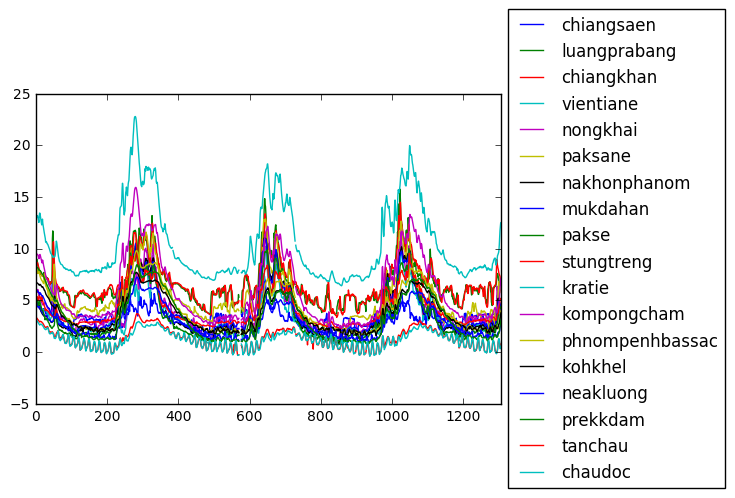

In [29]:
# ent,sta=np.where(pd.isnull(df_heights))
# for ii in ent:
#     print(df_heights.iloc[ii,-1])
df_heights.plot(legend=False)
plt.legend(bbox_to_anchor=(1.5, 1.3))

In [37]:
#extract river heights for JJASO only
def extractSeason(site):
    year=np.arange(2009,2017).astype(str)
    heights=np.loadtxt(dirr+site+'_JJASO_2008.txt',skiprows=0)
    for yr in year:
        heights=np.append(heights,np.loadtxt(dirr+site+'_JJASO_'+yr+'.txt',skiprows=0))                      
    return heights    
season_df=pd.DataFrame()
for i in sites:
    season_df[i[0]]=extractSeason(i[0])
print(len(season_df))

datelist = pd.date_range(start='06/01/2008',end='10/31/2008',freq='D')
print(len(datelist))
year=np.arange(2009,2017).astype(str)
for yr in year:
    datelist = np.append(datelist,pd.date_range(start='06/01/'+yr,end='10/31/'+yr,freq='D'))

season_df['date'] = datelist
season_df.set_index('date',inplace=True)

1377
153


## Load rain data

In [30]:
def extractRain(site):
    year=np.arange(2009,2017).astype(str)
    heights=np.loadtxt('../HydrologySection/river_analytics/MRC_rainfall/'+site+'_JJASO_2008.txt',skiprows=0)
    for yr in year:
        heights=np.append(heights,np.loadtxt('../HydrologySection/river_analytics/MRC_rainfall/'+site+'_JJASO_'+yr+'.txt',skiprows=0))                      
    return heights 
rain_df=pd.DataFrame()
for i in sites:
    rain_df[i[0]]=extractRain(i[0])
rain_df

datelist = pd.date_range(start='06/01/2008',end='10/31/2008',freq='D')
year=np.arange(2009,2017).astype(str)
for yr in year:
    datelist = np.append(datelist,pd.date_range(start='06/01/'+yr,end='10/31/'+yr,freq='D'))

rain_df['date'] = datelist
rain_df.set_index('date',inplace=True)
rain_df.fillna(value=0,inplace=True)
rain_df

,chiangsaen,luangprabang,chiangkhan,vientiane,nongkhai,paksane,nakhonphanom,mukdahan,pakse,stungtreng,kratie,kompongcham,phnompenhbassac,kohkhel,neakluong,prekkdam,tanchau,chaudoc
date,,,,,,,,,,,,,,,,,,
2008-06-01,2.9,6.8,0.0,5.2,7.6,40.8,0.0,0.0,2.5,0.0,0.0,0.0,0.7,20.9,0.0,0.0,12.4,0.0
2008-06-02,0.0,0.0,0.0,17.3,10.0,44.3,0.0,0.0,0.4,6.8,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
2008-06-03,27.9,22.9,15.3,34.6,6.2,27.2,6.7,26.0,0.0,55.1,18.6,31.0,6.3,0.3,0.0,5.2,0.0,0.2
2008-06-04,0.0,11.4,6.2,4.0,73.5,32.5,94.2,0.0,0.0,0.6,0.0,0.0,0.3,0.0,0.0,9.3,0.0,0.0
2008-06-05,32.3,1.2,3.0,90.8,0.0,39.2,21.3,36.8,23.9,0.0,0.0,7.5,0.0,0.0,0.0,7.5,0.0,0.0
2008-06-06,8.6,2.4,4.2,33.0,47.3,42.3,0.0,22.1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-06-07,11.2,0.0,9.7,40.6,31.5,88.8,57.5,5.3,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-06-08,3.4,0.0,1.6,1.6,0.5,0.4,1.7,2.6,0.0,0.0,0.0,0.0,0.0,0.5,3.8,0.0,0.4,0.0
2008-06-09,2.6,14.6,0.0,8.5,0.6,11.1,34.4,0.0,0.0,9.5,1.0,3.4,20.8,44.7,73.8,57.3,15.2,2.0


## Temperature data
Read from GHCND.  
GHCND-stations  

|Serial      |lat     |lon      |ele   |station nam                  |  
|--------------------------------------------------------------------|
|TH000048357 |17.4170 |104.7830 |148.0 |NAKHON PHANOM 48357          |  
|TH000048383 |16.5330 |104.7170 |139.0 |MUKDAHAN 48383               |
|LAM00048955 |15.1170 |105.1670 |102.0 |PAKSE 48955                  |
|LAW00041051 |17.9833 |102.5667 |170.1 |VIENTIANE                    |
|LAW00041061 |19.9000 |102.1667 |284.1 |LUANG PRABANG L 54           |
|LAW00041071 |15.1333 |105.7833 |102.1 |PAKSE L-11 (no date coverage)|
|CBM00048991 |11.5470 |104.8440 |12.2  |PHNOM PENH INTL 48991        |

In [31]:
def readGHCNdly(fileloc):
    colcol = [(0,11),(11,15),(15,17),(17,21)]
    for i in range(21,262,8):
        colcol.extend([(i,i+5),(i+5,i+6),(i+6,i+7),(i+7,i+8)])
    df=pd.io.parsers.read_fwf(fileloc,colspecs=colcol,header=None)
    return df

mukdahan_df=readGHCNdly('../HydrologySection/river_analytics/ghcnd_data/LAM00048955.dly')
# print(mukdahan_df[mukdahan_df[3]=='TMAX'])
mukdahan_df



,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,LAM00048955,1950,10,TMIN,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
1,LAM00048955,1950,10,PRCP,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
2,LAM00048955,1950,10,TAVG,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
3,LAM00048955,1951,7,TAVG,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
4,LAM00048955,1952,5,TAVG,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
5,LAM00048955,1952,6,TMIN,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
6,LAM00048955,1952,6,PRCP,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
7,LAM00048955,1952,6,TAVG,312,H,NaN,S,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
8,LAM00048955,1952,7,TAVG,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
9,LAM00048955,1952,8,TMIN,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,239,NaN,NaN,S


## Pressure, sea level pressure, surface pressure, windspeed (average, max, min)
Data from Global summary of the day (GSOD)

In [32]:
def readGSOD(fileloc):
    col = [(14,22),(24,30),(46,52),(57,63),(78,83),(102,108),(110,116)]
    df=pd.io.parsers.read_fwf(fileloc,colspecs=col,header=0)
    return df

mukdahan_gsod_df=readGSOD('../HydrologySection/river_analytics/GSOD_data/483830-99999-2008.op')
mukdahan_gsod_df['date']=pd.to_datetime(mukdahan_gsod_df['YEARMODA'],format='%Y%m%d')
for yr in range(2009,2017):    
    yr_df=readGSOD('../HydrologySection/river_analytics/GSOD_data/483830-99999-'+str(yr)+'.op')
    yr_df['date']=pd.to_datetime(yr_df['YEARMODA'],format='%Y%m%d')
    mukdahan_gsod_df = mukdahan_gsod_df.append(yr_df,ignore_index=True)

mukdahan_gsod_df
# mukdahan_gsod_df.set_index('date',inplace=True)
# md_gsod_df = mukdahan_gsod_df[((mukdahan_gsod_df.index.month == 6) & (8 <= mukdahan_gsod_df.index.day)) |\
#                  (mukdahan_gsod_df.index.month >= 7) & (mukdahan_gsod_df.index.month<=10) ]
msk = ((mukdahan_gsod_df['date'].dt.month >= 6) & (mukdahan_gsod_df['date'].dt.month <=10))
md_gsod_df = mukdahan_gsod_df[msk]
md_gsod_df.set_index('date',inplace=True)
# md_gsod_df.loc[:,('SLP')]=md_gsod_df['SLP']-1000
# md_gsod_df.loc[:,('STP')]=md_gsod_df['STP']-1000
# md_gsod_df.loc[:,('TEMP')]=md_gsod_df['TEMP']-80
# md_gsod_df.loc[:,('MAX')]=md_gsod_df['MAX']-80
# md_gsod_df.loc[:,('MIN')]=md_gsod_df['MIN']-80
md_gsod_df

,YEARMODA,TEMP,SLP,STP,WDSP,MAX,MIN
date,,,,,,,
2008-06-01,20080601,83.9,1005.0,989.3,0.2,93.2,77.4
2008-06-02,20080602,79.0,1007.0,991.1,1.0,87.6,73.4
2008-06-03,20080603,80.1,1007.8,992.0,0.2,87.3,72.9
2008-06-04,20080604,81.2,1008.0,992.2,0.7,92.5,75.2
2008-06-05,20080605,82.2,1005.5,989.8,0.7,90.7,74.5
2008-06-06,20080606,82.7,1006.4,990.6,1.0,93.2,75.2
2008-06-07,20080607,81.6,1007.9,992.0,0.0,89.4,74.3
2008-06-08,20080608,80.5,1008.1,992.2,0.9,90.1,77.0
2008-06-09,20080609,83.0,1007.0,991.2,1.0,92.1,76.8


## Combining all these datasets

In [33]:
# combining rain and gsod data
md_df = rain_df.join(md_gsod_df,how='left')
md_df = md_df[['mukdahan','TEMP','SLP','STP','WDSP','MAX','MIN']]
md_df

,mukdahan,TEMP,SLP,STP,WDSP,MAX,MIN
date,,,,,,,
2008-06-01,0.0,83.9,1005.0,989.3,0.2,93.2,77.4
2008-06-02,0.0,79.0,1007.0,991.1,1.0,87.6,73.4
2008-06-03,26.0,80.1,1007.8,992.0,0.2,87.3,72.9
2008-06-04,0.0,81.2,1008.0,992.2,0.7,92.5,75.2
2008-06-05,36.8,82.2,1005.5,989.8,0.7,90.7,74.5
2008-06-06,22.1,82.7,1006.4,990.6,1.0,93.2,75.2
2008-06-07,5.3,81.6,1007.9,992.0,0.0,89.4,74.3
2008-06-08,2.6,80.5,1008.1,992.2,0.9,90.1,77.0
2008-06-09,0.0,83.0,1007.0,991.2,1.0,92.1,76.8


In [34]:
#some data from GSOD is missing in 7 places.
arrrr = rain_df.reset_index()['date'].isin(md_gsod_df.reset_index()['date'])
print(arrrr.loc[~arrrr])
print(md_gsod_df.iloc[667])
print(rain_df.iloc[667])

702     False
865     False
960     False
1257    False
1258    False
1259    False
1264    False
1265    False
1266    False
1267    False
1268    False
1269    False
Name: date, dtype: bool
YEARMODA    20120726.0
TEMP              83.3
SLP             1004.9
STP              989.1
WDSP               2.6
MAX               93.0
MIN               75.2
Name: 2012-07-26 00:00:00, dtype: float64
chiangsaen         33.5
luangprabang       13.8
chiangkhan          9.6
vientiane           2.8
nongkhai            5.8
paksane             8.5
nakhonphanom        1.9
mukdahan            0.0
pakse               0.0
stungtreng          0.0
kratie              0.0
kompongcham         0.0
phnompenhbassac     0.0
kohkhel             0.0
neakluong           0.0
prekkdam            0.0
tanchau             0.0
chaudoc             0.0
Name: 2012-07-26 00:00:00, dtype: float64


In [35]:
#creating the features array
#array is made of the values of the past 7 days of the following features:
#rainfall, temperaure, station pressure, windspeed, max temperature,
#min temperature, river height
def makeXraw():
    ysize=len(md_df)
    xsize=ysize-7
    featuresize=57
    X_raw=np.empty([xsize,featuresize])
    for ii in range(7,ysize):
            X_raw[ii-7,0:7]=md_df['mukdahan'][ii-7:ii]
            X_raw[ii-7,7:14]=md_df['TEMP'][ii-7:ii]
            X_raw[ii-7,14:21]=md_df['STP'][ii-7:ii]
            X_raw[ii-7,21:28]=md_df['WDSP'][ii-7:ii]
            X_raw[ii-7,28:35]=md_df['MAX'][ii-7:ii]
            X_raw[ii-7,35:42]=md_df['MIN'][ii-7:ii]
            X_raw[ii-7,42:49]=season_df['mukdahan'][ii-7:ii]
            X_raw[ii-7,49:56]=md_df['SLP'][ii-7:ii]
    return X_raw

# Machine learning starts here
## Prediction for next day

(1265, 57)
(1265,)
error  -0.002399999999999965
rms error  0.21606270927585497


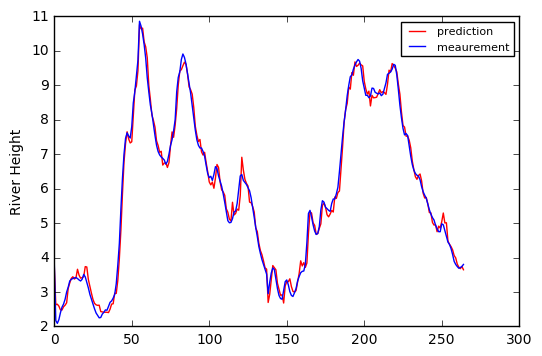

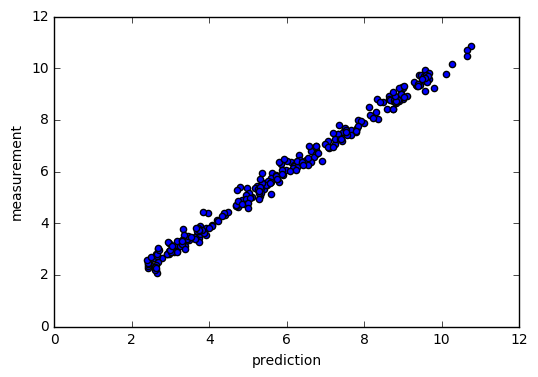

In [39]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR

#1-day prediction
X_raw=makeXraw()
temp_df = pd.DataFrame(X_raw)
temp_df['date']=datelist[7:]
temp_df.set_index('date',inplace=True)
temp_df = temp_df[((temp_df.index.month == 6) & (8 <= temp_df.index.day)) |\
                 (temp_df.index.month >= 7) & (temp_df.index.month<=10) ]

X_raw = temp_df.as_matrix()
y_raw = season_df[((season_df.index.month == 6) & (8 <= season_df.index.day)) |\
                 (season_df.index.month >= 7) & (season_df.index.month<=10) ]

X_raw[:,56]=np.array(y_raw['mukdahan'])
Xa=X_raw[~np.isnan(X_raw).any(axis=1)]
y=np.copy(Xa[:,56])
X=Xa
X[:,56]=1 #regularization term
print(X.shape)
print(y.shape)
np.argwhere(np.isnan(y_raw['mukdahan']))

# X=preprocessing.scale(X)
reg1d = RandomForestRegressor(n_estimators=10)
# reg1d = GaussianProcessRegressor(n_restarts_optimizer=100)
# reg1d = SVR(kernel='poly',verbose=True)
# reg1d = linear_model.LinearRegression()
reg1d.fit(X[:1000,:],y[:1000])
# print(reg1d.coef_)
pred=reg1d.predict(X[1000:,:])
print('error ',np.mean(pred-y[1000:]))
print('rms error ',np.sqrt(np.mean((pred-y[1000:])**2)))

plt.figure(1)
plt.plot(pred,c='r',label='prediction')
plt.plot(y[1000:],c='b',label='meaurement')
plt.ylabel('River Height')
plt.legend(prop={'size':8})

plt.figure(2)
plt.scatter(pred,y[1000:])
plt.xlabel('prediction')
plt.ylabel('measurement')

## Prediction 2-days out

(1305, 57)
(1256, 57)
(1256,)
[-4.60628324e-04 -9.58928489e-04 -2.56487973e-04  5.17385931e-04
  4.87026934e-04  3.42949194e-04 -7.94912509e-04 -5.69833777e-03
  7.28261889e-03 -1.22937453e-03  1.86019577e-02 -1.91180840e-02
 -2.24835141e-02 -3.08158948e-02 -2.43356108e-02  1.16839544e-01
  3.58728657e-01 -7.00858403e-02 -1.04800584e-02  4.80697561e-01
  4.60064882e-02 -9.23613725e-03  2.32098681e-03  4.73243068e-03
  2.91399624e-03  2.14323626e-02 -7.53778455e-03 -1.35297309e-02
  6.61324696e-03  6.18593865e-03 -9.71162123e-04  1.10781402e-02
  5.25751084e-04 -1.94269213e-02 -1.80500158e-02  6.15471318e-03
 -2.68965986e-03 -2.55367148e-02 -2.61652590e-03  6.19611627e-03
  3.36321471e-02 -2.92416353e-03  3.34933627e-02 -1.18763208e-01
  2.29507277e-01 -4.96348285e-01  1.06523971e+00 -2.03232193e+00
  2.27431345e+00 -8.92634447e-03 -9.16078691e-02 -3.51062161e-01
  8.45826718e-02 -1.31467858e-02 -5.17677402e-01 -2.86818313e-02
  0.00000000e+00]
average error 0.009092064512539168
rms err

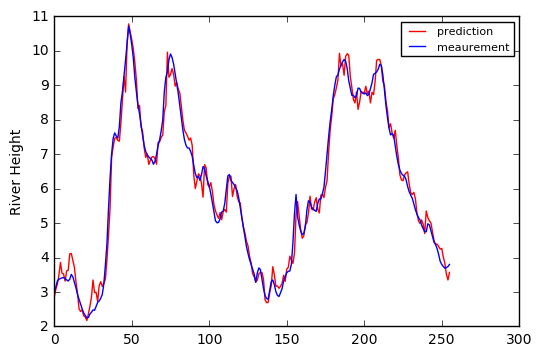

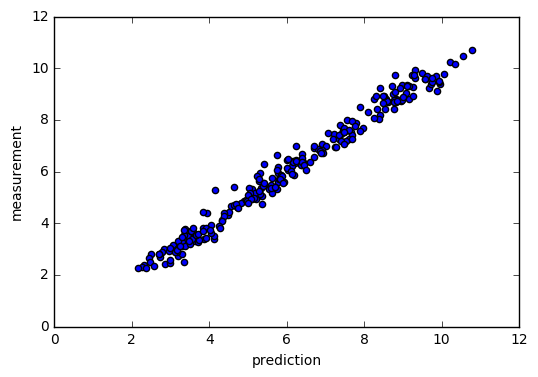

In [41]:
X_raw=makeXraw()
temp_df = pd.DataFrame(X_raw)
temp_df['date']=datelist[7:]
temp_df.set_index('date',inplace=True)
temp_df = temp_df[((temp_df.index.month == 6) & (8 <= temp_df.index.day)) |\
                 ((temp_df.index.month >= 7) & (temp_df.index.month<=9)) | \
                 ((temp_df.index.month == 10) & (30 >= temp_df.index.day))]

X_raw = temp_df.as_matrix()
print(X_raw.shape)


y_raw = season_df[((season_df.index.month == 6) & (9 <= season_df.index.day)) |\
                 ((season_df.index.month >= 7) & (season_df.index.month<=10))]

X_raw[:,56]=np.array(y_raw['mukdahan'])
Xa=X_raw[~np.isnan(X_raw).any(axis=1)]
y=np.copy(Xa[:,56])
X=Xa
X[:,56]=1 #regularization term
print(X.shape)
print(y.shape)
np.argwhere(np.isnan(y_raw['mukdahan']))

# X=preprocessing.scale(X)
reg2d = linear_model.LinearRegression()
# reg2d = RandomForestRegressor(n_estimators=10)
reg2d.fit(X[:1000,:],y[:1000])
print(reg2d.coef_)
pred=reg2d.predict(X[1000:,:])
print('average error',np.mean(pred-y[1000:]))
print('rms error ',np.sqrt(np.mean((pred-y[1000:])**2)))
plt.figure(1)
plt.plot(pred,c='r',label='prediction')
plt.plot(y[1000:],c='b',label='meaurement')
plt.ylabel('River Height')
plt.legend(prop={'size':8})

plt.figure(2)
plt.scatter(pred,y[1000:])
plt.xlabel('prediction')
plt.ylabel('measurement')

## Prediction 3 days out

(1296, 57)
(1247, 57)
(1247,)
average error -0.017315789473684257
rms error  0.6448030016455988


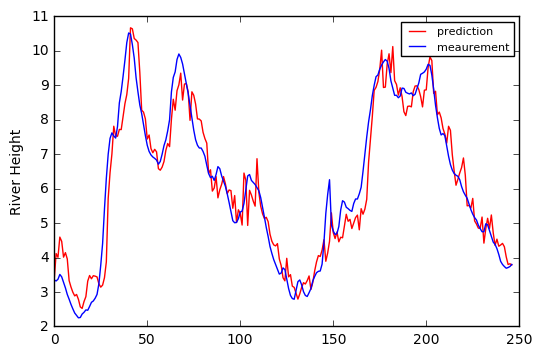

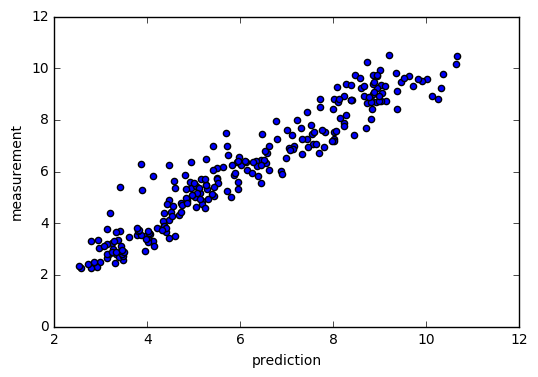

In [42]:
#3-day prediction
X_raw=makeXraw()

temp_df = pd.DataFrame(X_raw)
temp_df['date']=datelist[7:]
temp_df.set_index('date',inplace=True)
temp_df = temp_df[((temp_df.index.month == 6) & (8 <= temp_df.index.day)) |\
                 ((temp_df.index.month >= 7) & (temp_df.index.month<=9)) | \
                 ((temp_df.index.month == 10) & (29 >= temp_df.index.day))]

X_raw = temp_df.as_matrix()
print(X_raw.shape)


y_raw = season_df[((season_df.index.month == 6) & (10 <= season_df.index.day)) |\
                 ((season_df.index.month >= 7) & (season_df.index.month<=10))]

X_raw[:,56]=np.array(y_raw['mukdahan'])
Xa=X_raw[~np.isnan(X_raw).any(axis=1)]
y=np.copy(Xa[:,56])
X=Xa
X[:,56]=1 #regularization term
print(X.shape)
print(y.shape)
np.argwhere(np.isnan(y_raw['mukdahan']))

# X=preprocessing.scale(X)
reg3d = RandomForestRegressor(n_estimators=10)
# reg3d.fit(X[:1000,:], y[:1000])
# reg3d = linear_model.LinearRegression()
reg3d.fit(X[:1000,:],y[:1000])
# print(reg3d.coef_)
pred=reg3d.predict(X[1000:,:])
print('average error',np.mean(pred-y[1000:]))
print('rms error ',np.sqrt(np.mean((pred-y[1000:])**2)))

plt.figure(1)
plt.plot(pred,c='r',label='prediction')
plt.plot(y[1000:],c='b',label='meaurement')
plt.ylabel('River Height')
plt.legend(prop={'size':8})

plt.figure(2)
plt.scatter(pred,y[1000:])
plt.xlabel('prediction')
plt.ylabel('measurement')

## Prediction 5 days out

(1278, 57)
(1229, 57)
(1229,)
[-1.53920930e-02 -4.43956036e-02 -3.30086295e-02 -3.13960821e-02
 -1.46806859e-02  1.22245794e-02  7.44186505e-03 -9.19674860e-02
 -2.48076344e-02 -3.58094408e-02  6.00959878e-03 -4.92992290e-02
 -1.37291624e-02 -2.72107130e-01 -3.06699772e-01  4.32647467e-01
  1.50742405e+00  1.53980616e+00  4.40793031e-01  7.87128103e-01
 -5.57331294e-01 -2.47207544e-02 -2.03900584e-02 -7.65373354e-03
  1.55441897e-02  4.11880133e-02  2.10914188e-02  3.81290555e-02
  1.17453967e-01  6.55218693e-02  5.81335297e-02  1.09359795e-01
  5.54354396e-02 -6.03806756e-03 -1.20185384e-01 -7.27480870e-04
 -3.63907061e-03 -6.40498553e-02 -5.28832037e-02 -2.51339987e-02
  6.70866129e-02  4.34969519e-02  4.44783667e-01 -6.17859686e-01
  7.37239823e-01 -1.43200554e+00  2.77831165e+00 -5.36431496e+00
  5.68984022e+00  2.00091010e-01 -4.90062776e-01 -1.51178612e+00
 -1.48113796e+00 -5.76942271e-01 -7.34604989e-01  1.98819091e-01
  0.00000000e+00]
average error -0.14045233956751174
rms err

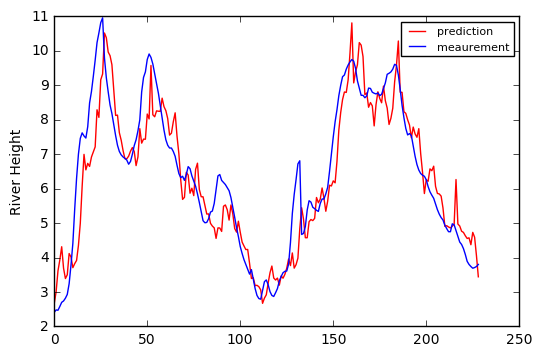

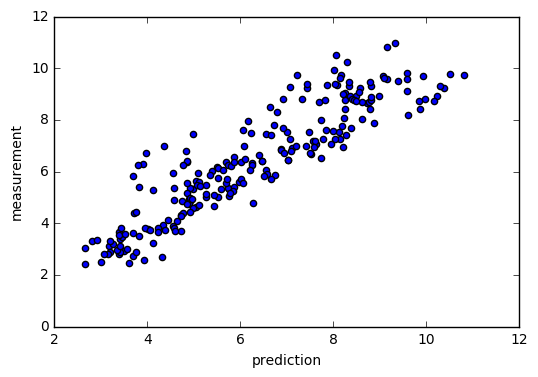

In [43]:
#5-day prediction
X_raw=makeXraw()

temp_df = pd.DataFrame(X_raw)
temp_df['date']=datelist[7:]
temp_df.set_index('date',inplace=True)
temp_df = temp_df[((temp_df.index.month == 6) & (8 <= temp_df.index.day)) |\
                 ((temp_df.index.month >= 7) & (temp_df.index.month<=9)) | \
                 ((temp_df.index.month == 10) & (27 >= temp_df.index.day))]

X_raw = temp_df.as_matrix()
print(X_raw.shape)


y_raw = season_df[((season_df.index.month == 6) & (12 <= season_df.index.day)) |\
                 ((season_df.index.month >= 7) & (season_df.index.month<=10))]

X_raw[:,56]=np.array(y_raw['mukdahan'])
Xa=X_raw[~np.isnan(X_raw).any(axis=1)]
y=np.copy(Xa[:,56])
X=Xa
X[:,56]=1 #regularization term
print(X.shape)
print(y.shape)
np.argwhere(np.isnan(y_raw['mukdahan']))

X=preprocessing.scale(X)
reg5d = linear_model.LinearRegression()
reg5d.fit(X[:1000,:],y[:1000])
print(reg5d.coef_)
pred=reg5d.predict(X[1000:,:])
print('average error',np.mean(pred-y[1000:]))
print('rms error ',np.sqrt(np.mean((pred-y[1000:])**2)))

plt.figure(1)
plt.plot(pred,c='r',label='prediction')
plt.plot(y[1000:],c='b',label='meaurement')
plt.ylabel('River Height')
plt.legend(prop={'size':8})

plt.figure(2)
plt.scatter(pred,y[1000:])
plt.xlabel('prediction')
plt.ylabel('measurement')